# Definition and study of indicators

In this notebook, we address the Task 1.2, i.e. the extraction of indicators for describing the incidents. First we will compute the indicators on different features combinations, visualizing their distributions. Then, we will study the correlation between the indicators and choose the most relevant ones. (SEMANTICA)

We import the libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import seaborn as sns
sys.path.append(os.path.abspath('..'))
from plot_utils import *
%matplotlib inline

We load the dataset and reaname some columns:

In [3]:
incidents_df = pd.read_csv('../data/incidents_cleaned.csv')
incidents_df['date'] = pd.to_datetime(incidents_df['date'], format='%Y-%m-%d')
incidents_df.rename(
    columns={
        'congressional_district': 'congd',
        'min_age_participants': 'min_age',
        'avg_age_participants': 'avg_age',
        'max_age_participants': 'max_age',
        'n_participants_child': 'n_child',
        'n_participants_teen': 'n_teen',
        'n_participants_adult': 'n_adult',
        'location_importance': 'location_imp'
    },
    inplace=True
)
dataset_original_columns = incidents_df.columns

First, we compute a set of indicators aimed at highlighting the degree of abnormality of the value of a specific feature of an incident with respect to the values of the same feature in the incidents happened in the same period and/or in the same geographical area. 

The following function computes for each record the ratio between the value of a specific feature in that record and the value of an aggregation function (e.g. sum or mean) applied to the feature restricted to a certain time and space window:

In [4]:
def compute_window_ratio_indicator(df, gby, feature, agg_fun, suffix):
	grouped_df = df.groupby(gby)[feature].agg(agg_fun)
	df = df.merge(grouped_df, on=gby, how='left', suffixes=[None, suffix])
	df[feature+suffix+'_ratio'] = df[feature] / df[feature+suffix]
	df.loc[np.isclose(df[feature], 0), feature+suffix+'_ratio'] = 1 # set to 1 when 0/0
	df.drop(columns=[feature+suffix], inplace=True)
	return df

We apply that function to most of the numerical features of the dataset, using:
- as aggregation functions the sum and the mean
- as time window the semester of the year or the whole year
- as space window the congressional district of the state or the whole state

We chose not to use 'county' or 'city' as space window because not all the records have a value for those features (e.g. incidents happend in rural areas). The values of the congressional districts are instead always present (we have previously inferred the missing ones).

In [5]:
# numerical columns to use
window_features = [
    'n_males',
    'n_females',
    'n_killed',
    'n_injured',
    'n_arrested',
    'n_unharmed',
    'n_participants',
    'avg_age',
    'max_age',
    'min_age',
    'n_adult',
    'n_teen',
    'n_child'
]

# we associate to each incident the semester of the year in which it happened
incidents_df['sem'] = (incidents_df['date'].dt.month // 7) + 1

for feature in window_features:
    # feature / (sum(feature) in the same semester and congressional district)
    incidents_df = compute_window_ratio_indicator(
        df=incidents_df,
        gby=['year', 'sem', 'state', 'congd'],
        feature=feature,
        agg_fun='sum',
        suffix='_sum_sem_congd'
    )
    # feature / (sum(feature) in the same year and state)
    incidents_df = compute_window_ratio_indicator(
        df=incidents_df,
        gby=['year', 'state'],
        feature=feature,
        agg_fun='sum',
        suffix='_sum_year_state'
    )
    # feature / (mean(feature) in the same semester and congressional district)
    incidents_df = compute_window_ratio_indicator(
        df=incidents_df,
        gby=['year', 'sem', 'state', 'congd'],
        feature=feature,
        agg_fun='mean',
        suffix='_mean_sem_congd'
    )
    # feature / (mean(feature) in the same year and state)
    incidents_df = compute_window_ratio_indicator(
        df=incidents_df,
        gby=['year', 'state'],
        feature=feature,
        agg_fun='mean',
        suffix='_mean_year_state'
    )
# store the names of the new features
window_ratios_wrt_mean = []
window_ratios_wrt_total = []
for feature in incidents_df.columns:
    if 'mean' in feature:
        window_ratios_wrt_mean.append(feature)
    elif 'sum' in feature:
        window_ratios_wrt_total.append(feature)

We visualize the distributions of the ratios w.r.t the mean:

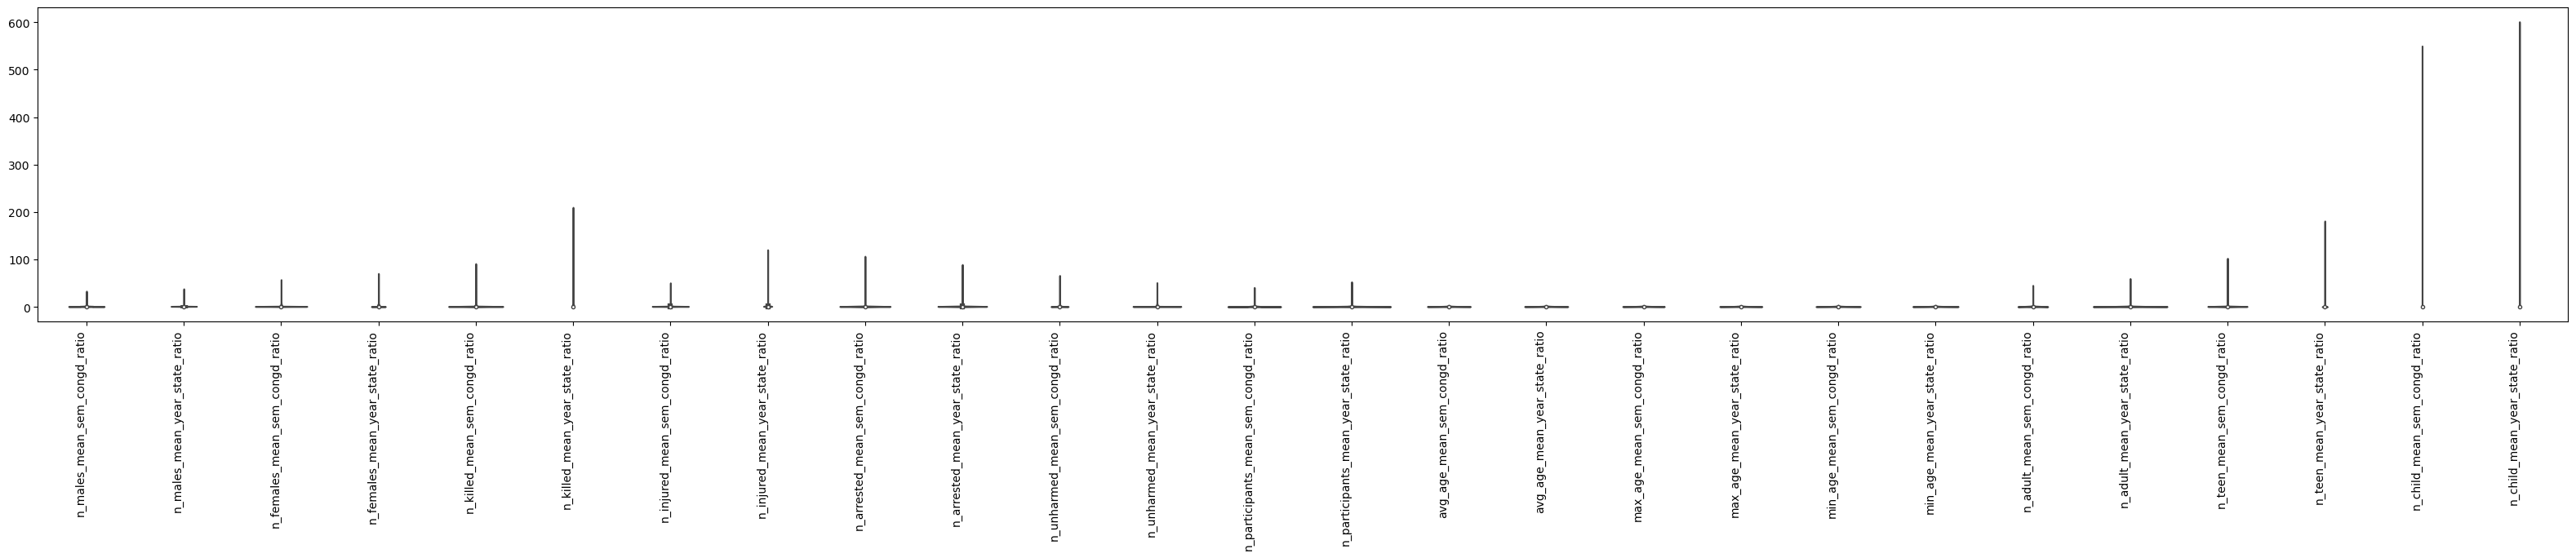

In [6]:
fig, ax = plt.subplots(figsize=(40, 5))
sns.violinplot(data=incidents_df[window_ratios_wrt_mean], ax=ax)
plt.xticks(rotation=90, ha='right');

All the distributions are highly skewed. The indicators about the number of killed people, the number of teens and the number of child have far outliers.

We define a function to apply a logarithmic transformation of a set of features (summing 1% of the minimum value of the feature excluding 0 to avoid infinite values):

In [7]:
def log_transform(df, features):
    for col in features:
        eps = (df[df[col]!=0][col].min())/100 # 1% of the minimum value
        df['log_'+col] = np.log(df[col] + eps)
    return df

We apply a logarithmic transformation to the ratio indicators displayed above:

In [8]:
incidents_df = log_transform(df=incidents_df, features=window_ratios_wrt_mean)
# store the names of the transformed features
log_window_ratios_mean = []
for feature in window_ratios_wrt_mean:
    log_window_ratios_mean.append('log_'+feature)

We visualize the distributions of the features after the transformation:

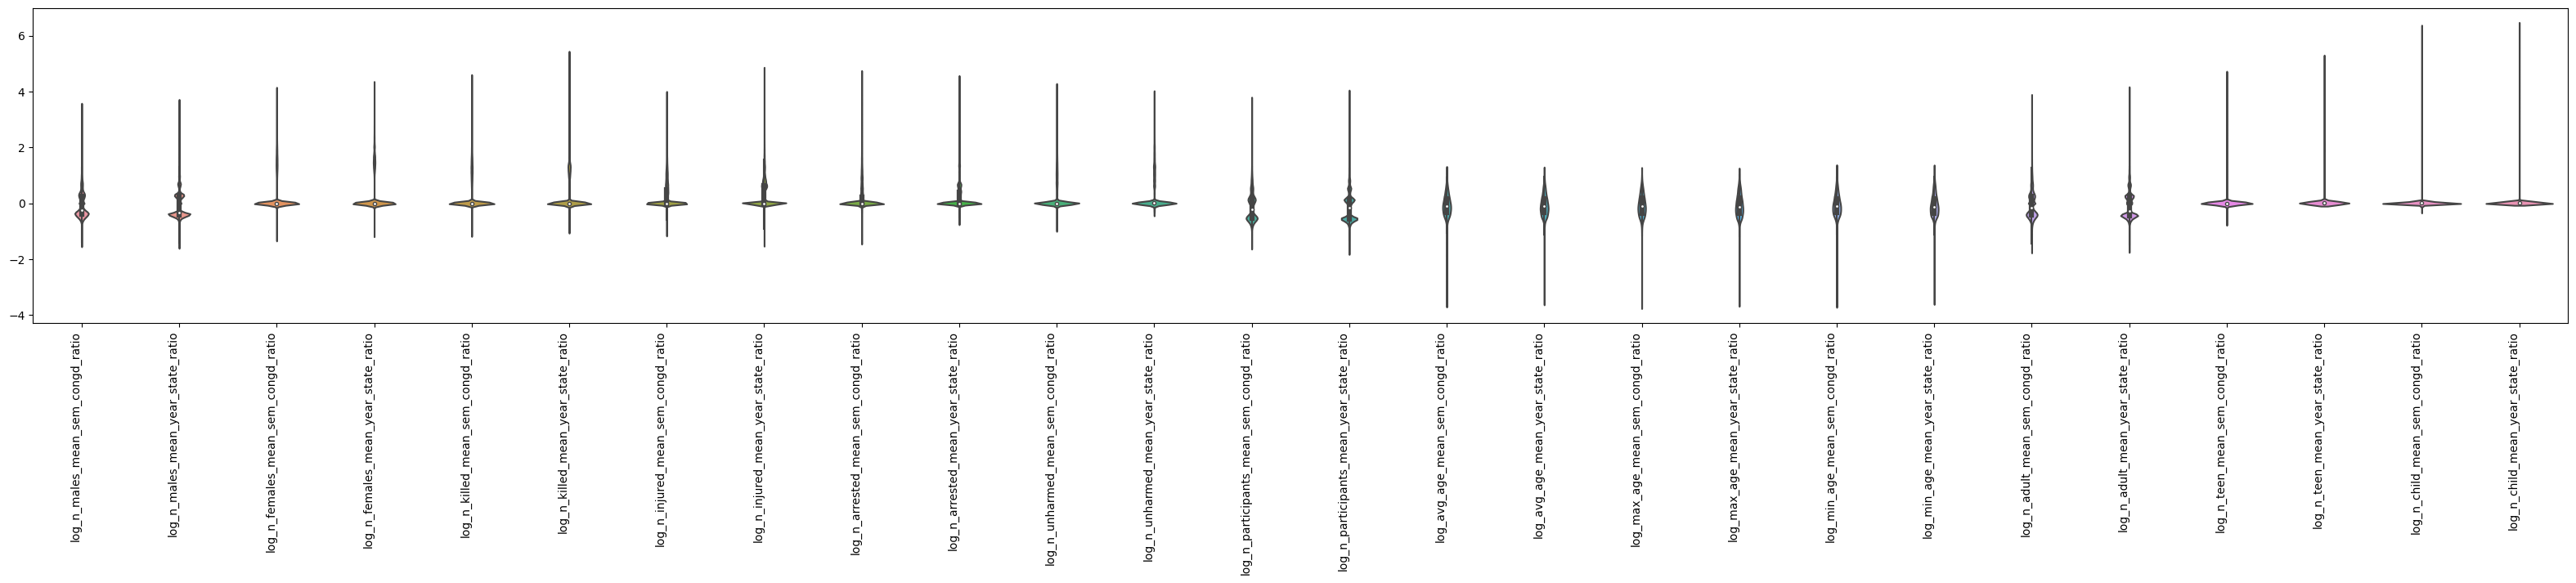

In [9]:
fig, ax = plt.subplots(figsize=(40, 5))
sns.violinplot(data=incidents_df[log_window_ratios_mean], ax=ax)
plt.xticks(rotation=90, ha='right');

As expected the logarithmic transformation reduced the skeweness of the distributions, but outliers are still present.

We visualize the distributions of the indicators w.r.t the total:

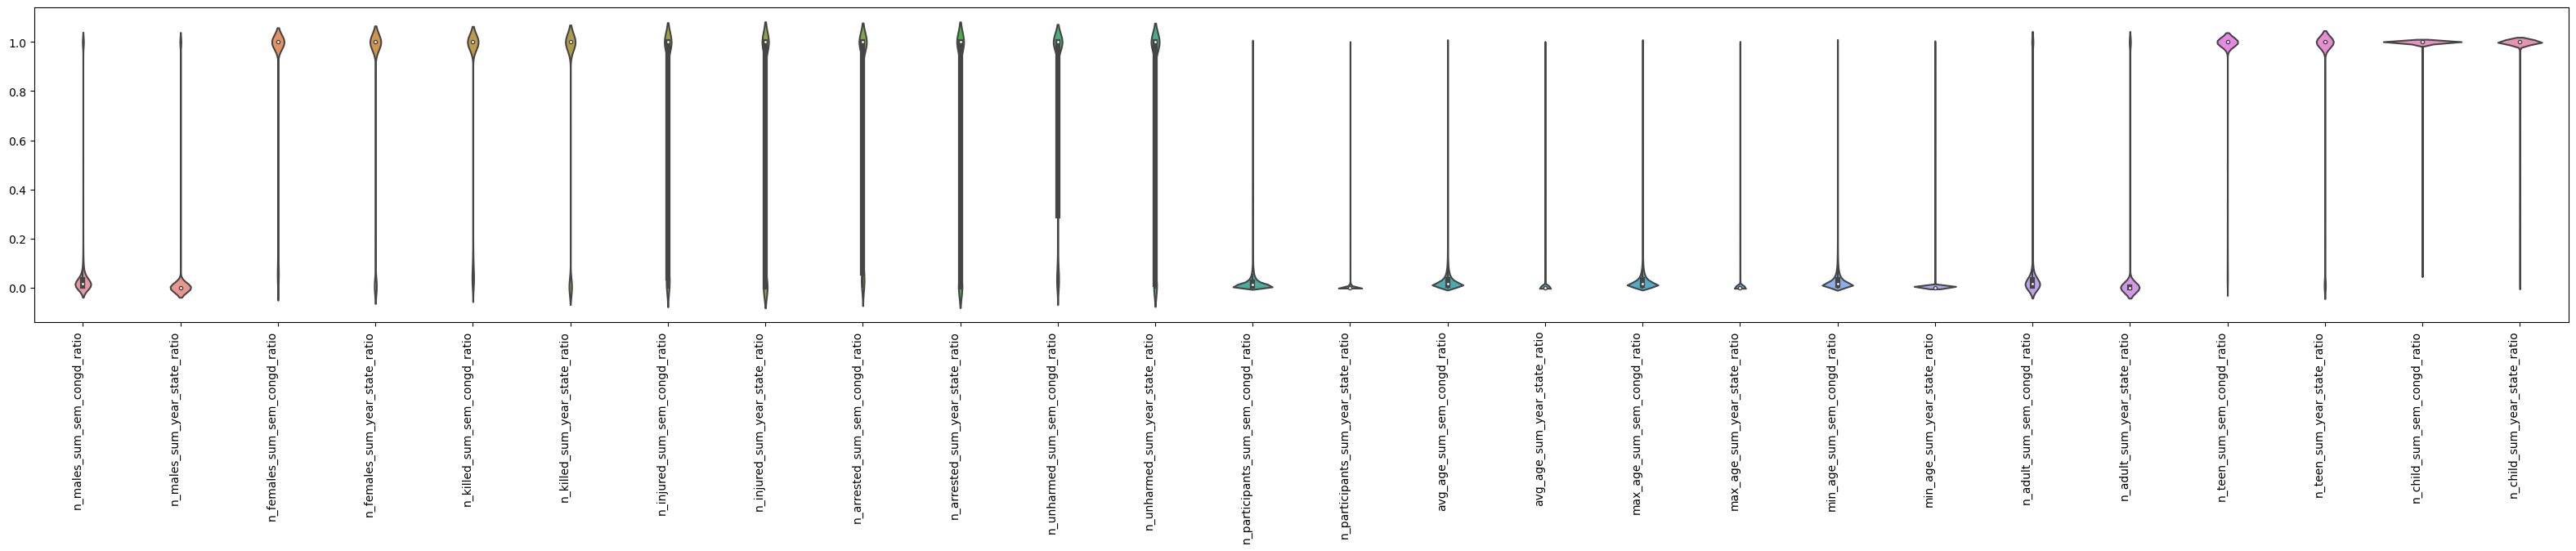

In [10]:
fig, ax = plt.subplots(figsize=(40, 5))
sns.violinplot(data=incidents_df[window_ratios_wrt_total], ax=ax)
plt.xticks(rotation=90, ha='right');

We apply the logarithmic transformation to the ratio indicators w.r.t the total and visualize the distributions after the transformation:

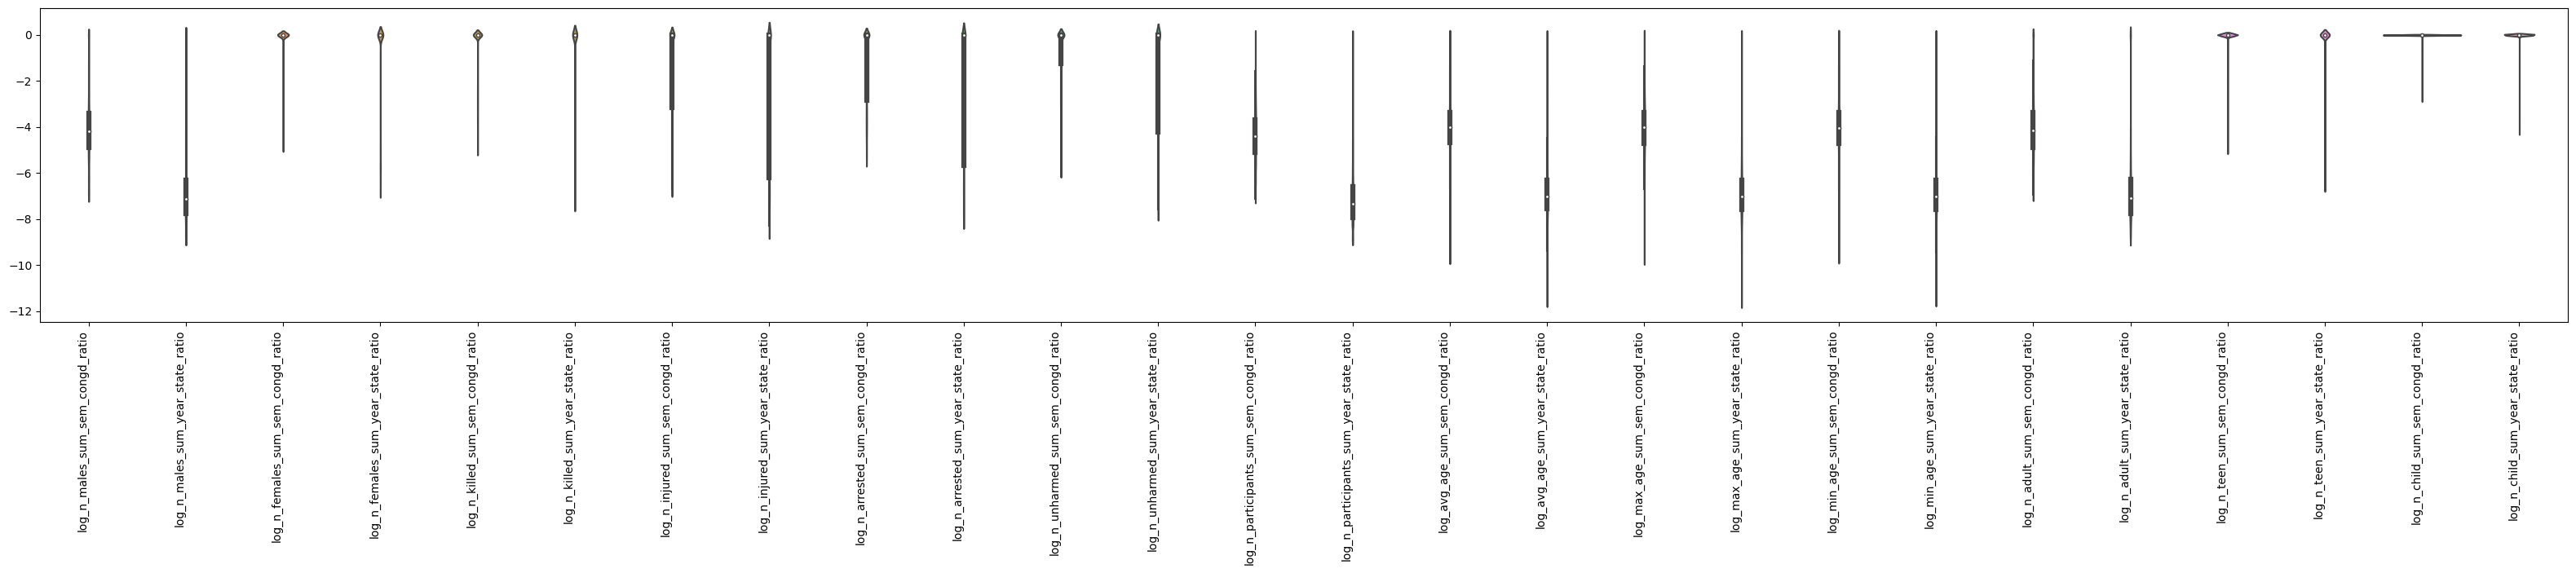

In [11]:
incidents_df = log_transform(df=incidents_df, features=window_ratios_wrt_total)
# store the names of the transformed features
log_window_ratios_total = []
for feature in window_ratios_wrt_total:
    log_window_ratios_total.append('log_'+feature)
# visualize the distributions of the features
fig, ax = plt.subplots(figsize=(40, 5))
sns.violinplot(data=incidents_df[log_window_ratios_total], ax=ax)
plt.xticks(rotation=90, ha='right');

We now compute indicators using only the data of each single record.
In particulat, we define a function to compute the ratio between the value a feature in a record w.r.t the value of another feature in the same record:

In [12]:
def compute_record_level_ratio_indicator(df, num, den):
    df[num+'_'+den+'_ratio'] = df[num] / df[den]
    return df

We use the function defined above to compute the ratio between the cardinality of a subset of participants and the total number of participants involved in the incident and we visualize the distributions of the computed indicators:

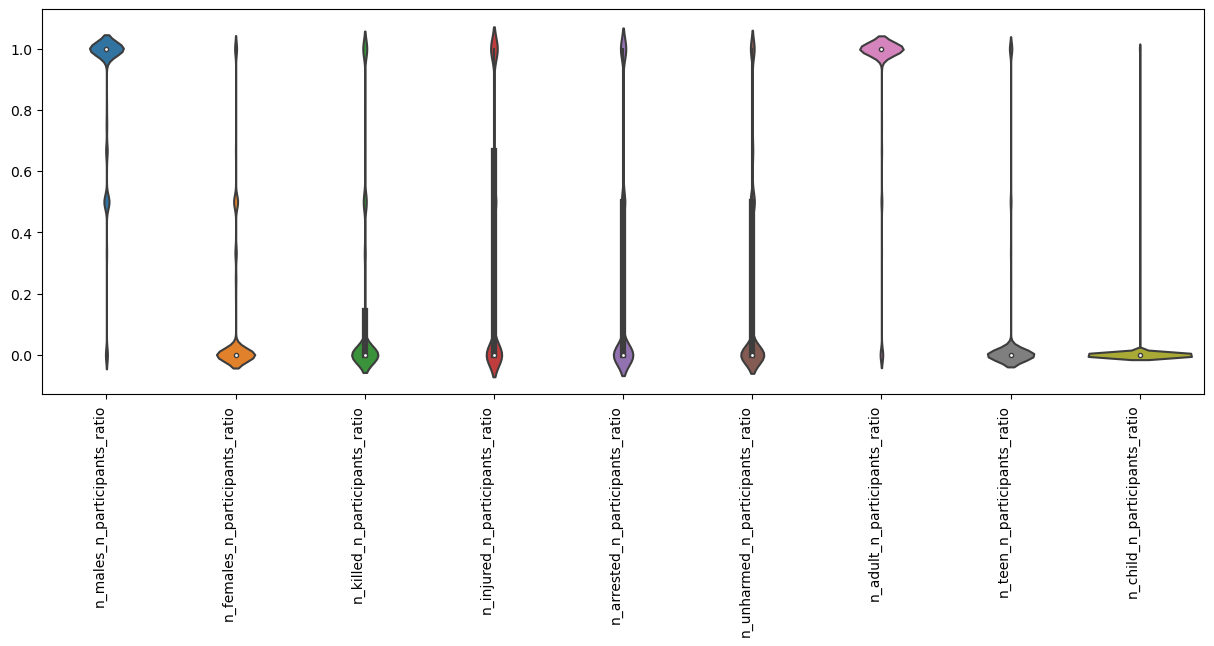

In [13]:
incident_ratio_num_columns = ['n_males', 'n_females', 'n_killed', 'n_injured', 'n_arrested', 'n_unharmed', 'n_adult', 'n_teen', 'n_child']
for feature in incident_ratio_num_columns:
    incidents_df = compute_record_level_ratio_indicator(df=incidents_df, num=feature, den='n_participants')
# store the names of the new features
record_level_ratios = []
for feature in incidents_df.columns:
    if 'ratio' in feature:
        if 'mean' not in feature and 'sum' not in feature:
            record_level_ratios.append(feature)
# visualize the distributions of the features
fig, ax = plt.subplots(figsize=(15, 5))
sns.violinplot(data=incidents_df[record_level_ratios], ax=ax)
plt.xticks(rotation=90, ha='right');

Maschi adulti. 

We now compute a set of indicators with a similar semantics to the ones computed above, but using the concept of **surprisal**.

This kind of indicator can also be computed for categorical variables, as well as for a set of variables.

The **surprisal** (also called [Information content](https://en.wikipedia.org/wiki/Information_content)) of an event $E$ 
with probability $p(E)$ is defined as $log(1/p(E))$ (or equivalently $-log(p(E))$).
Surprisal is inversly related to probability (hence the term $1/p(E)$): when $p(E)$ is close to $1$, the surprisal of the event is low, when $p(E)$ is close to $0$, the surprisal of the event is high.
The $log$ gives $0$ surprise when the probability of the event is $1$.

The surprisal is closely related to **entropy**, which is the expected value of the information content of a random variable, quantifying how surprising the random variable is "on average".

The following function computes the surprisal of a set of features of an incident w.r.t the values of the same features in the incidents happened in the same period and/or geographical area:

In [14]:
def compute_surprisal_indicator(df, fixed_cols, var_cols):
    occ = df.groupby(fixed_cols)[var_cols].value_counts().reset_index(name='occ')
    tot = df.groupby(fixed_cols).size().reset_index(name='total')
    probs = occ.merge(tot, how='left', on=fixed_cols)

    label = 'surprisal'
    for attr in var_cols:
        label += '_' + attr
    label += '_fixing'
    for attr in fixed_cols:
        label += '_' + attr

    probs[label] = -np.log2(probs['occ']/probs['total'])
    probs.drop(columns=['occ', 'total'], inplace=True)
    
    df = df.merge(probs, how='left', on=fixed_cols+var_cols)

    return df

We now compute the surprisal for a feature at a time fixing the semester of the year or the year only, and the congressional district in the state or the state only:

In [15]:
surpisal_single_features = ['month', 'day', 'address_type', 'n_child', 'n_teen', 'n_adult', 'min_age', 'avg_age', 'max_age', 'n_killed', 'n_injured', 'n_males', 'n_participants']
for feature in surpisal_single_features:
    incidents_df = compute_surprisal_indicator(df=incidents_df, fixed_cols=['year', 'sem', 'state', 'congd'], var_cols=[feature])
    incidents_df = compute_surprisal_indicator(df=incidents_df, fixed_cols=['year', 'state'], var_cols=[feature])

And we also compute the surprisal for a set of features:

In [16]:
incidents_df = compute_surprisal_indicator(df=incidents_df, fixed_cols=['year', 'sem', 'state', 'congd'], var_cols=['month', 'day'])
incidents_df = compute_surprisal_indicator(df=incidents_df, fixed_cols=['year', 'sem', 'state', 'congd'], var_cols=['n_child', 'n_teen', 'n_adult'])

incidents_tags = [
    'firearm', 'air_gun', 'shots', 'aggression',
    'suicide', 'injuries', 'death', 'road',
    'illegal_holding', 'house', 'school', 'children',
    'drugs', 'officers', 'organized', 'social_reasons',
    'defensive', 'workplace', 'abduction', 'unintentional'
    ]
incidents_df = compute_surprisal_indicator(df=incidents_df, fixed_cols=['year', 'sem', 'state', 'congd'], var_cols=incidents_tags)
incidents_df.rename(columns={incidents_df.columns[-1]: 'surprisal_characteristics'}, inplace=True)

We store in a list the names of the features just computed:

In [17]:
surprisals = []
for feature in incidents_df.columns:
    if 'surprisal' in feature:
        surprisals.append(feature)

We visualize the distributions of the surprisal indicators:

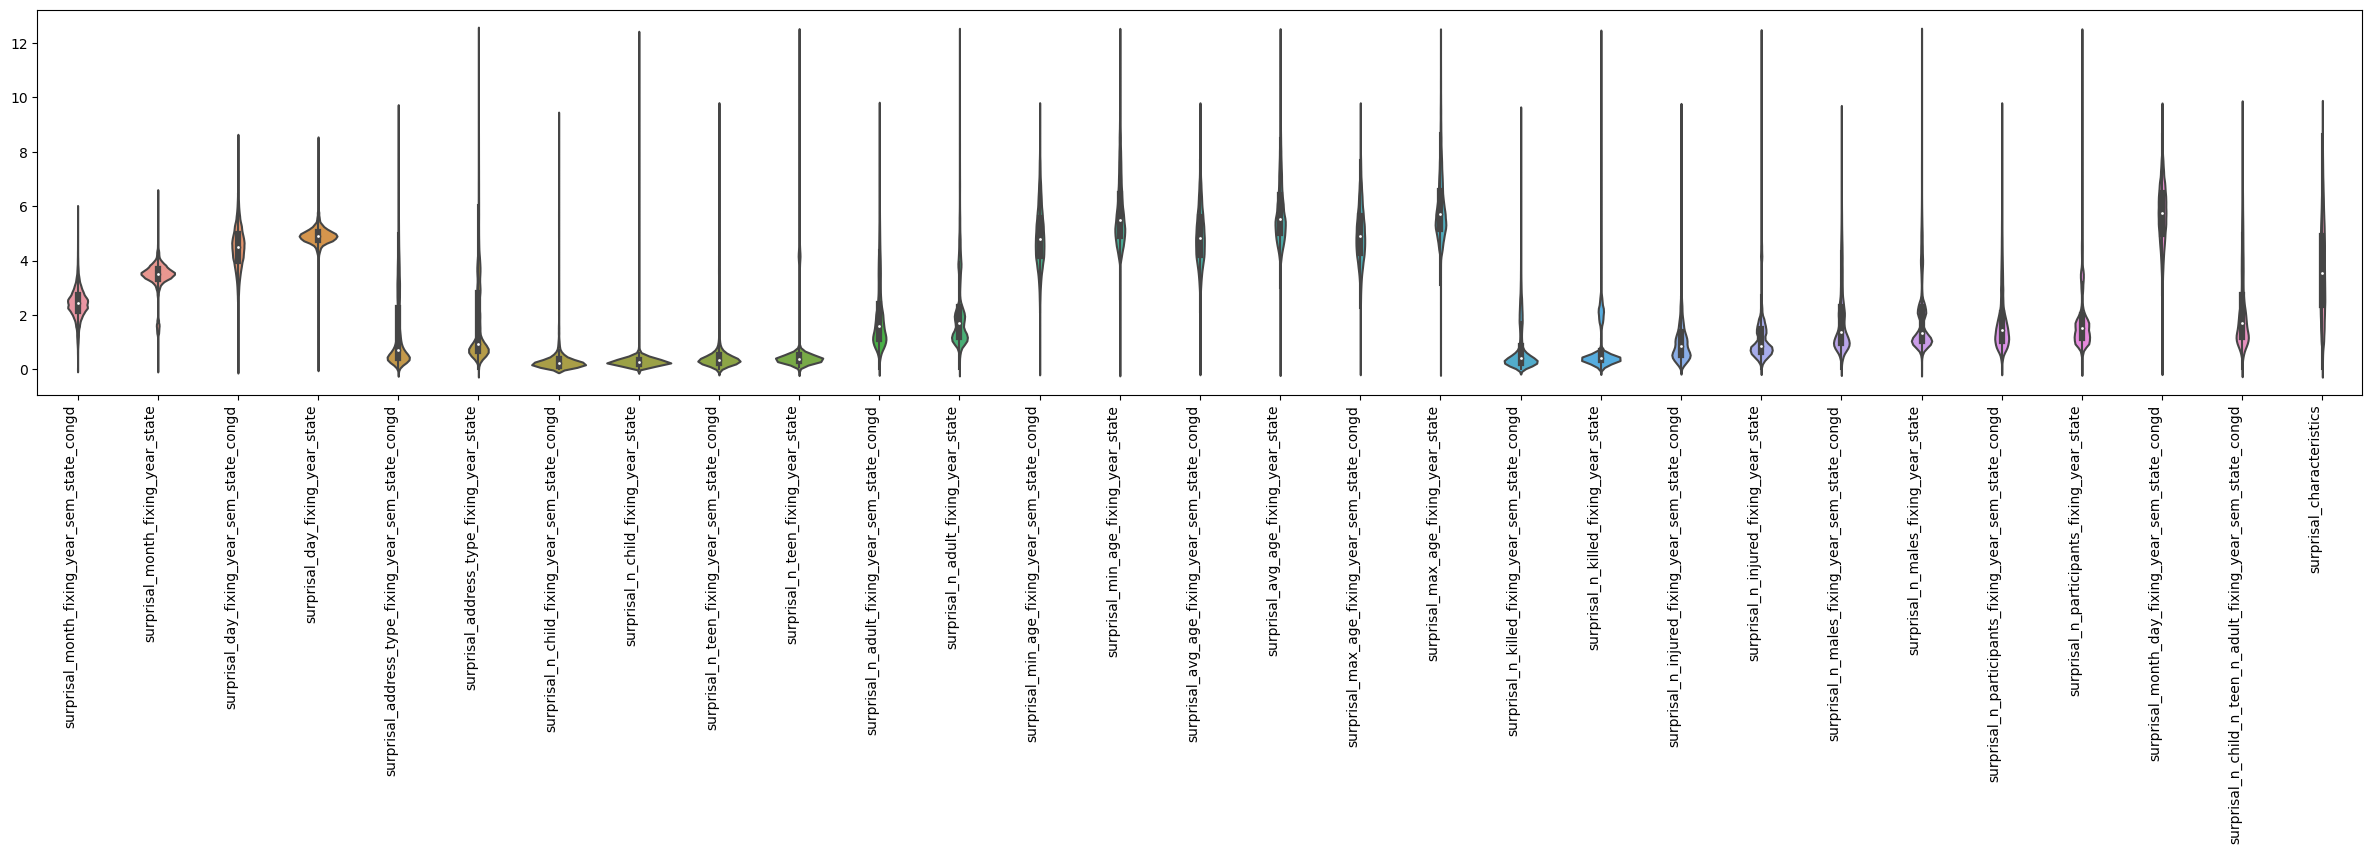

In [18]:
fig, ax = plt.subplots(figsize=(30, 5))
sns.violinplot(data=incidents_df[surprisals], ax=ax)
plt.xticks(rotation=90, ha='right');

TODO: commentare

We also define an indicator to measure the severity of an incident, based on the number of killed and injured people and we visualize its distribution:

<Axes: >

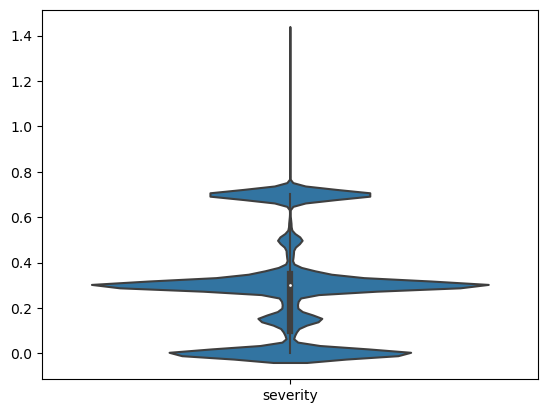

In [19]:
incidents_df['severity'] = (
    0.7*incidents_df['n_killed'] + \
    0.3*incidents_df['n_injured']
    ) / (incidents_df['n_participants']-incidents_df['n_unharmed'])
incidents_df['severity'].replace([np.inf], 0, inplace=True)
sns.violinplot(data=incidents_df[['severity']])

Additionally, we compute the age rage of the participants involved in the incident and we visualize its distribution:

<Axes: >

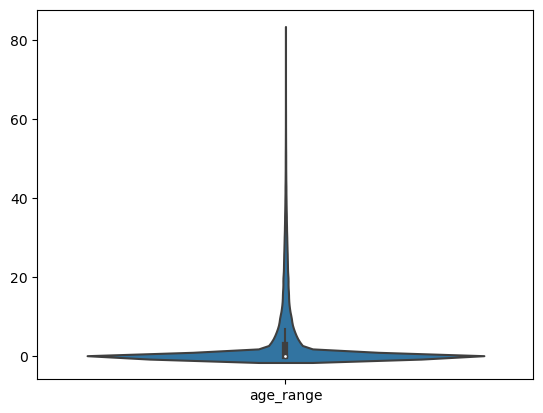

In [20]:
incidents_df['age_range'] = incidents_df['max_age'] - incidents_df['min_age']
sns.violinplot(data=incidents_df[['age_range']])

In [21]:
import utm # TODO: probabilmente andranno tolte

def project_lat_long(latidude, longitude):
    # check if the coordinates are valid
    if latidude >= -90 and latidude <= 90 and longitude >= -180 and longitude <= 180:
        utm_coordinates = utm.from_latlon(latidude, longitude)
        return utm_coordinates[0], utm_coordinates[1]
    else:
        return np.nan, np.nan

incidents_df['lat_proj'], incidents_df['lon_proj'] = zip(*incidents_df.apply(
    lambda row: project_lat_long(row['latitude'], row['longitude']), axis=1))

In [22]:
indicators_abbr = {
    # spatial data
    'lat_proj': 'lat_proj',
    'lon_proj': 'lon_proj',
    'location_imp': 'location_imp',
    'surprisal_address_type_fixing_year_sem_state_congd': 'surprisal_address_type',
    # age data
    'age_range': 'age_range',
    'avg_age': 'avg_age',
    'surprisal_min_age_fixing_year_sem_state_congd': 'surprisal_min_age',
    'log_min_age_mean_sem_congd_ratio': 'log_min_age_mean_ratio',
    'n_child_n_participants_ratio': 'n_child_prop',
    'n_teen_n_participants_ratio': 'n_teen_prop',
    'surprisal_n_child_n_teen_n_adult_fixing_year_sem_state_congd': 'surprisal_age_groups',
    # severity data
    'severity': 'severity',
    'n_killed_n_participants_ratio': 'n_killed_prop',
    'surprisal_n_killed_fixing_year_sem_state_congd': 'surprisal_n_killed',
    'log_n_killed_mean_sem_congd_ratio': 'log_n_killed_mean_ratio',
    'n_injured_n_participants_ratio': 'n_injured_prop',
    'log_n_injured_mean_sem_congd_ratio': 'log_n_injured_mean_ratio',
    'surprisal_n_injured_fixing_year_sem_state_congd': 'surprisal_n_injured',
    'n_unharmed_n_participants_ratio': 'n_unharmed_prop',
    # gender data
    'n_males_n_participants_ratio': 'n_males_prop',
    'log_n_males_mean_sem_congd_ratio': 'log_n_males_mean_ratio',
    'surprisal_n_males_fixing_year_sem_state_congd': 'surprisal_n_males',
    # characteristics data
    'surprisal_characteristics': 'surprisal_characteristics',
    'n_arrested_n_participants_ratio': 'n_arrested_prop',
    'log_n_participants_mean_sem_congd_ratio': 'log_n_participants_mean_ratio',
    'surprisal_n_participants_fixing_year_sem_state_congd': 'surprisal_n_participants',
    'n_participants': 'n_participants',
    # temporal data
    'surprisal_month_day_fixing_year_sem_state_congd': 'surprisal_day'
}

In [23]:
incidents_df.rename(columns=indicators_abbr, inplace=True)

<Axes: >

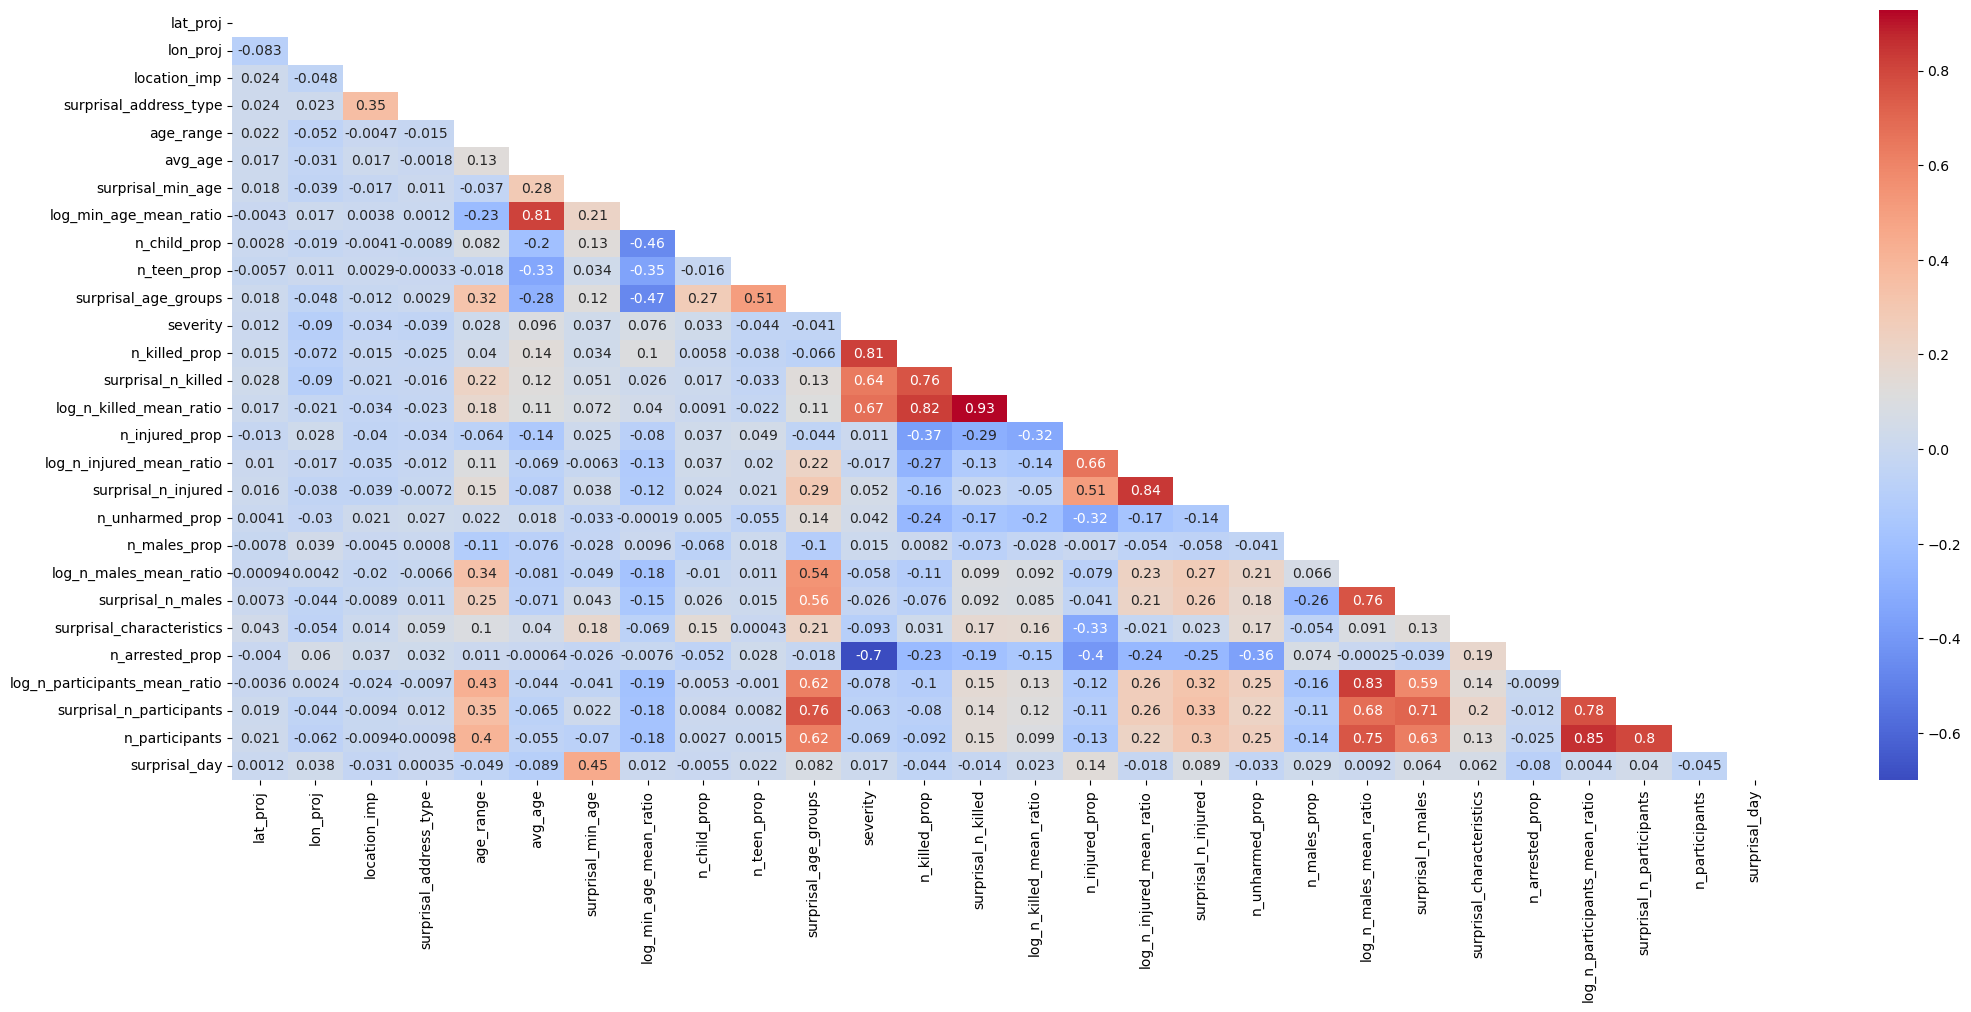

In [24]:
fig, ax = plt.subplots(figsize=(25, 10))
corr_matrix = incidents_df[list(indicators_abbr.values())].corr('pearson')
sns.heatmap(corr_matrix, annot=True, ax=ax, mask=np.triu(corr_matrix), cmap='coolwarm')

<Axes: >

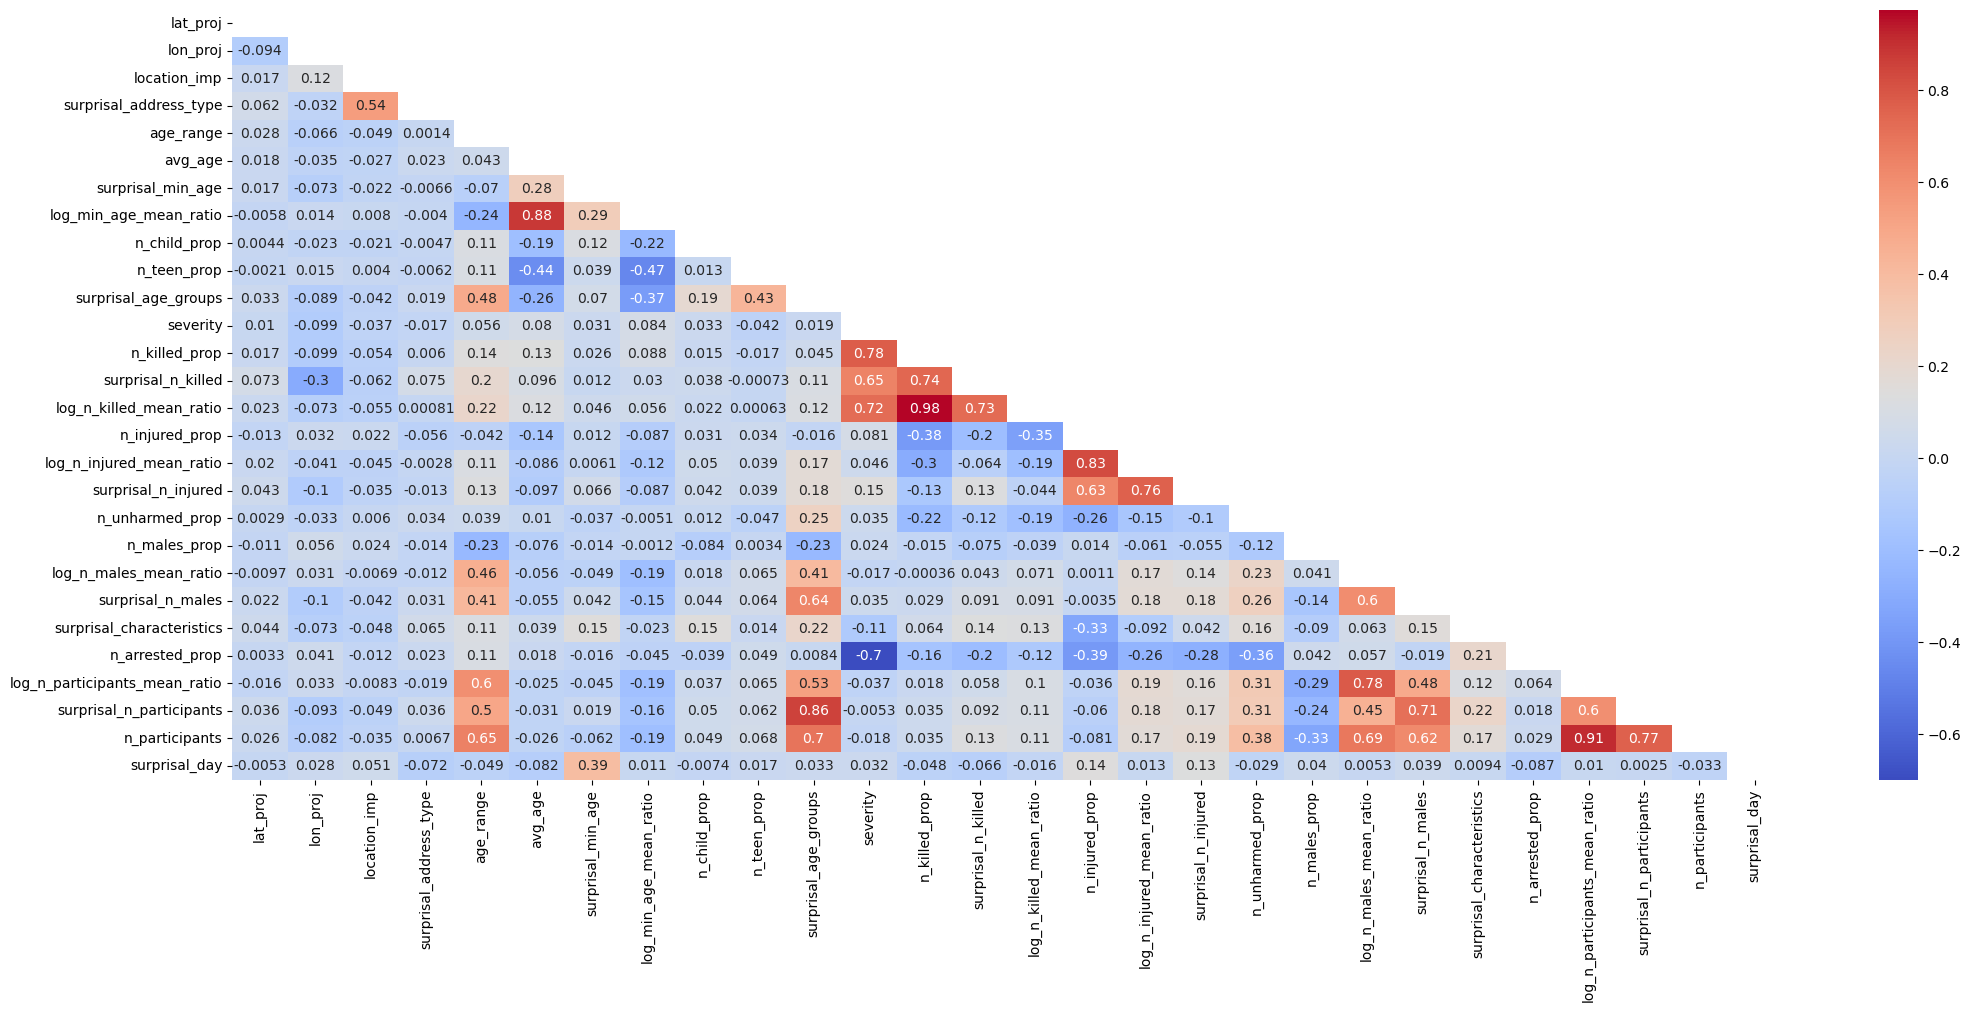

In [25]:
fig, ax = plt.subplots(figsize=(25, 10))
corr_matrix = incidents_df[list(indicators_abbr.values())].corr('spearman')
sns.heatmap(corr_matrix, annot=True, ax=ax, mask=np.triu(corr_matrix), cmap='coolwarm')

In [26]:
features_to_drop = [
    'log_min_age_mean_ratio', 
    'severity',
    'log_n_killed_mean_ratio',
    'log_n_injured_mean_ratio',
    'surprisal_n_killed',
    'surprisal_n_injured', # discarded to reduce dimensionality
    'log_n_males_mean_ratio',
    'log_n_participants_mean_ratio',
    'surprisal_n_participants',
    # surprisal_age_groups
]
indicators = [feature for feature in list(indicators_abbr.values()) if feature not in features_to_drop]

<Axes: >

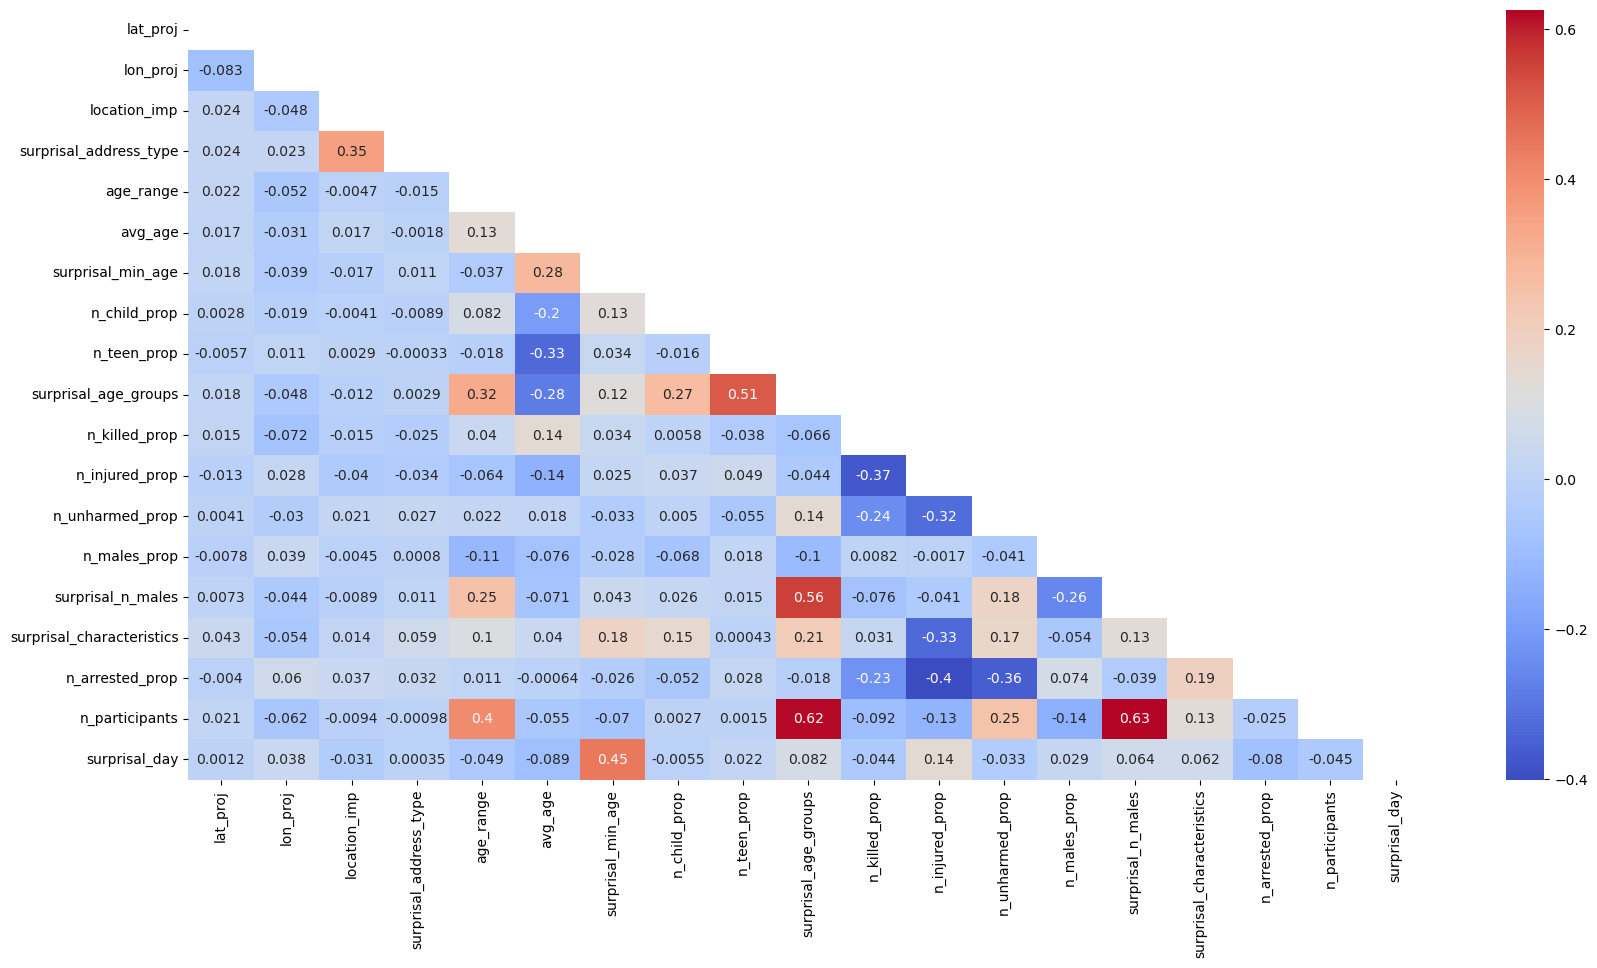

In [27]:
fig, ax = plt.subplots(figsize=(20, 10))
corr_matrix = incidents_df[indicators].corr('pearson')
sns.heatmap(corr_matrix, annot=True, ax=ax, mask=np.triu(corr_matrix), cmap='coolwarm')

<Axes: >

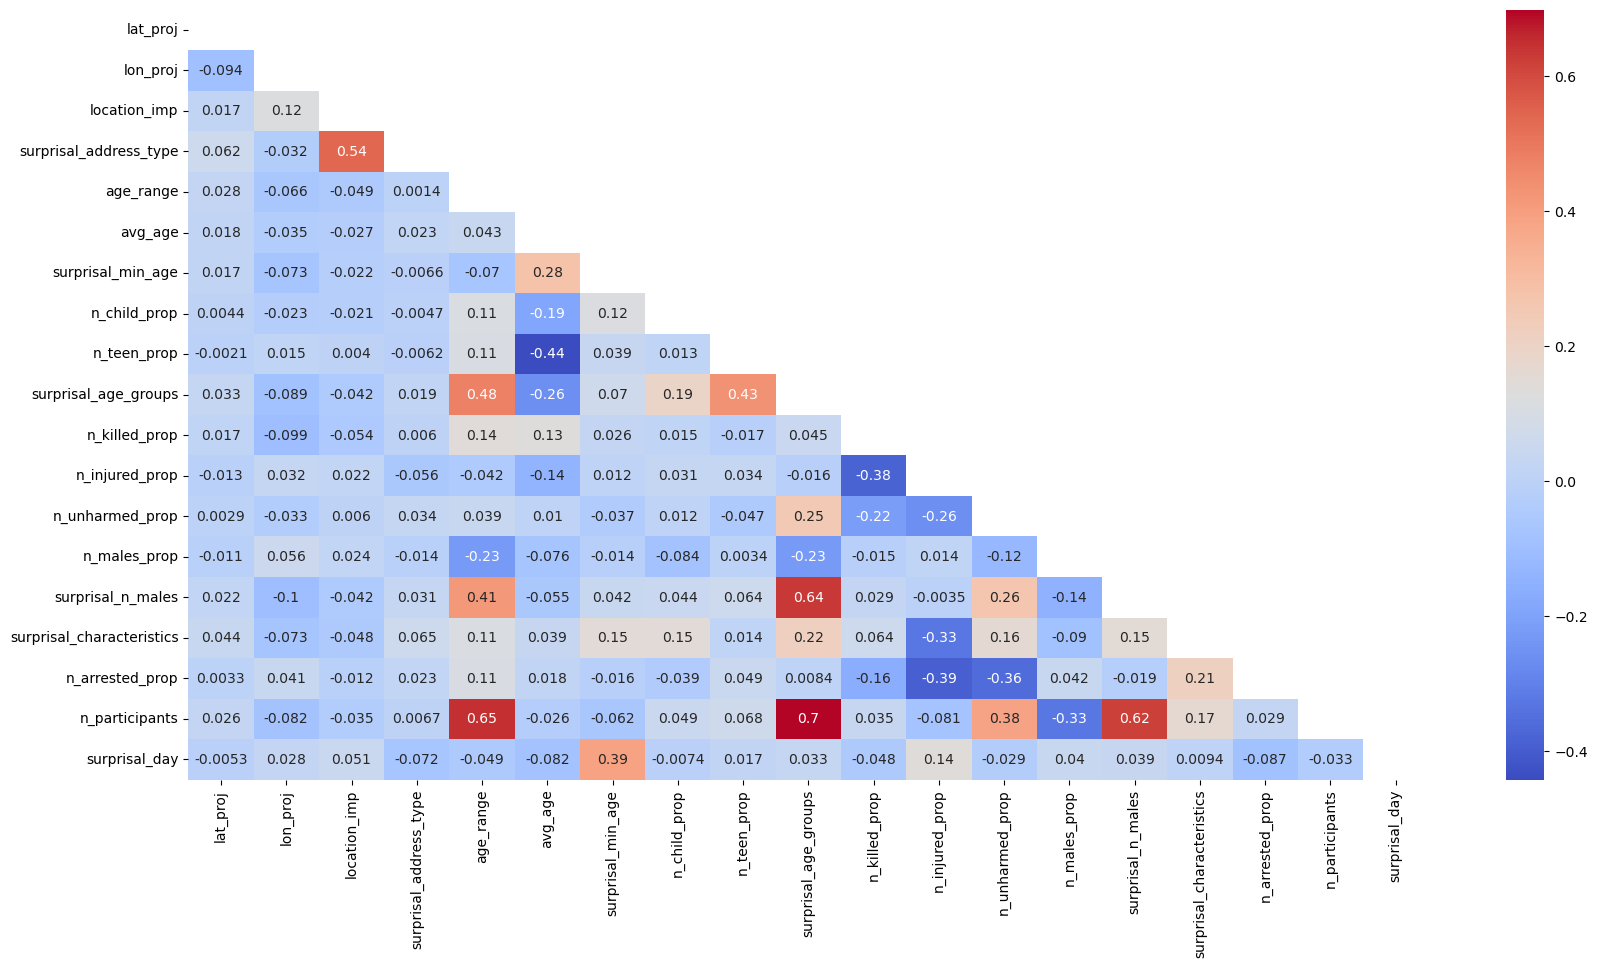

In [28]:
fig, ax = plt.subplots(figsize=(20, 10))
corr_matrix = incidents_df[indicators].corr('spearman')
sns.heatmap(corr_matrix, annot=True, ax=ax, mask=np.triu(corr_matrix), cmap='coolwarm')

In [29]:
print(incidents_df.shape[0])
print(incidents_df[indicators].dropna().shape[0])

237055
130521


In [30]:
import json
with open('../data/indicators_names.json', 'w') as f:
    json.dump(indicators, f)

In [31]:
origianal_features_minus_indicators = [feature for feature in dataset_original_columns if feature not in indicators]
incidents_df[origianal_features_minus_indicators + indicators].to_csv('../data/incidents_indicators.csv')
incidents_df[indicators].to_csv('../data/indicators.csv')

## Indicators semanthics

| Name | Description | Present in the original dataset |
| :--: | :---------: | :-----------------------------: |
| lat_proj | Latitude projection using Universal Transverse Mercator system | No |
| long_proj | Longitude projection using Universal Transverse Mercator system | No |
| location_imp | Location importance according to Geopy | No |
| surprisal_address_type | Surprisal of the address type w.r.t the address types of incidents happened in the same semester of the same year and in the congressional district of the same state | No |
| age_range | Difference between the maximum and the minimum age of the participants involved in the incident | No |
| avg_age | Average age of the participants involved in the incident | Yes |
| surprisal_min_age | Surprisal of the minimum age of the participants involved in the incident w.r.t the minimum age of the participants of incidents happened in the same semester of the same year and in the congressional district of the same state | No |
| n_child_prop | Ratio between the number of child involved in the incident and number of people involved in the incident | No |
| n_teen_prop | Ratio between the number of teen involved in the incident and number of people involved in the incident | No |
| surprisal_age_groups | Surprisal of the number of child, teen and adult involved in the incident w.r.t the number of child, teen and adult involved in incidents happened in the same semester of the same year and in the congressional district of the same state | No |
| n_killed_prop | Ratio between the number of people killed and number of people involved in the incident | No |
| n_injured_prop | Ratio between the number of people injured and number of people involved in the incident | No |
| n_unharmed_prop | Ratio between the number of people unharmed and number of people involved in the incident | No |
| n_males_prop | Ratio between the number of males and the number of people involed in the incident | No |
| surprisal_n_males | Surprisal of the number of males involved in the incident w.r.t the number of males involved in incidents happened in the same semester of the same year and in the congressional district of the same state | No |
| surprisal_characteristics | Surprisal of the values of the incident characteristic tags extracted from the incident characteristics w.r.t the values of the tags for incidents happened in the same semester of the same year and in the congressional district of the same state | No |
| n_arrested_prop | Ratio between the number of people arrested and the number of participants involved in the incident | No |
| n_participants | Number of participants in the incident | Yes |
| surprisal_day | Surprisal of the day of the month and of the month of the incident w.r.t the days of the month and the months of incidents happened in the same semester of the same year and in the congressional district of the same state | No |